# TEAM ID : PTID-AI-DEC-24-1063

# BATCH ID : 15-JUL-24-AIE-BUN-071-WDM11-BAN

# **PROJECT NAME : PRAICP-1001-GenderDetc**

### Business Case:  
  
Develop a machine learning model that can predict the Gender of a person in the frame.


### PROJECT GOAL:
1. Image preprocessing
2. ML model to predict the Gender.

# 1- Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import random as rnd
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
# Keras library
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3,InceptionResNetV2, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf

## 2. Parameter Setup for Model Training

In [ ]:
BATCH_SIZE = 16
image_height = 128
image_width = 128

# 3- Load DataSet

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## Extract Compressed Files

In [ ]:
# execute this only once... if you run again, skip this part
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/AI project/PRAICP-1001-GenderDetc/PRAICP-1001-GenderDetc2.zip", 'r') as zip_ref:        # get the path for train.zip using copypath. paste the link within the quotation
     # creates new folder and saves all images present in train.zip
    zip_ref.extractall("/content/extracted_images")  # create a new folder, rename it and get the path of it using copypath.. paste the link here



In [ ]:
files_list = os.listdir("/content/extracted_images")

# Count the number of files
num_files = len(files_list)
print(num_files)
# Print the names of the files
for file_name in files_list:
    print(file_name)

1
Data


In [ ]:
files_list = os.listdir("/content/extracted_images/Data")

# Count the number of files
num_files = len(files_list)
print(num_files)
# Print the names of the files
for file_name in files_list:
    print(file_name)

1
gender_dataset_face


In [ ]:
import os
import shutil

# Define source directories
man_dir = "/content/extracted_images/Data/gender_dataset_face/man"
woman_dir = "/content/extracted_images/Data/gender_dataset_face/woman"
train_dir = "/content/extracted_images/train"

# Create combined directory if it doesn't exist
os.makedirs(train_dir, exist_ok=True)

# Function to copy only image files with labels
def copy_images(source_dir, label, dest_dir):
    valid_extensions = {".jpg", ".jpeg", ".png"}  # Allow only image files
    for index, filename in enumerate(os.listdir(source_dir)):
        src_path = os.path.join(source_dir, filename)
        ext = os.path.splitext(filename)[1].lower()

        if os.path.isfile(src_path) and ext in valid_extensions:
            dest_path = os.path.join(dest_dir, f"{label}_{index}{ext}")  # Preserve extension
            shutil.copy(src_path, dest_path)

# Copy man images with label 0
copy_images(man_dir, 0 , train_dir)

# Copy woman images with label 1
copy_images(woman_dir, 1 , train_dir)

print("Images successfully merged and labeled!")


Images successfully merged and labeled!


In [ ]:
import os
from PIL import Image


# Counter for deleted files
deleted_count = 0

# Loop through all files in the train directory
for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)

    try:
        # Open the image to check its validity
        with Image.open(file_path) as img:
            img.verify()  # Check if it's a valid image

    except (IOError, SyntaxError):
        print(f"Deleting corrupted image: {file_path}")
        os.remove(file_path)  # Delete corrupted file
        deleted_count += 1

print(f"\n✅ Deletion complete! {deleted_count} corrupted images removed.\n")



✅ Deletion complete! 0 corrupted images removed.



In [ ]:
train_images = os.listdir(train_dir)
CATEGORIES = []

for image_name in train_images:
    class_name = image_name.split('_')[0]  # cat.588.jpg
    CATEGORIES.append(0 if class_name=='0' else 1)

df = pd.DataFrame({"train_images": train_images, "CATEGORIES": CATEGORIES})

In [ ]:
df.head()

train_images  CATEGORIES
0    1_823.jpg           1
1    1_681.jpg           1
2    0_577.jpg           0
3    1_738.jpg           1
4    0_347.jpg           0

In [ ]:
df.tail()

train_images  CATEGORIES
2302    1_817.jpg           1
2303   0_1070.jpg           0
2304    1_559.jpg           1
2305    0_604.jpg           0
2306    1_268.jpg           1

In [ ]:
df.describe()

CATEGORIES
count  2307.000000
mean      0.491547
std       0.500037
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [ ]:
df["CATEGORIES"].value_counts()

CATEGORIES
0    1173
1    1134
Name: count, dtype: int64

> ## Visualize The Data

<Axes: xlabel='CATEGORIES'>

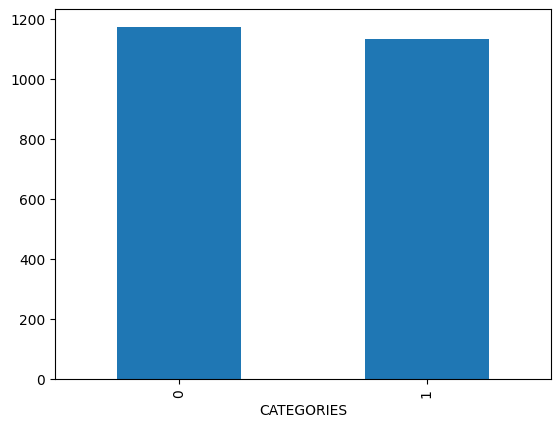

In [ ]:
df["CATEGORIES"].value_counts().plot.bar()

> ## *From our data we have 1173 man and 1034 women*

In [ ]:
shapes = []
# minimum dimensions will be stored here
min_height = float('inf')
min_width = float('inf')
min_shape_index = -1

for index, image in enumerate(df["train_images"]):
    path = os.path.join(train_dir, image)
    image_array = plt.imread(path)
    shapes.append(image_array.shape)

    # Check if current image has minimum height and width
    # Check if the image has 3 channels (RGB) or 2 channels (grayscale)
    if len(image_array.shape) == 3:
        height, width, _ = image_array.shape
    else:
        height, width = image_array.shape

    if height < min_height and width < min_width:
        min_height = height
        min_width = width
        min_shape_index = index

print(pd.Series(shapes).value_counts())

# Print the index and dimensions of the image with minimum dimensions
print(f"\nThe index of image with Minimum Dimension is ==> {min_shape_index}\n")
print(f"\nThe Minimum Dimension is ==> {shapes[min_shape_index]}\n")

(146, 106, 3)    4
(86, 67, 3)      4
(147, 113, 3)    4
(129, 101, 3)    3
(154, 121, 3)    3
                ..
(334, 263, 3)    1
(240, 187, 3)    1
(149, 124, 3)    1
(186, 149, 3)    1
(211, 173, 3)    1
Name: count, Length: 2125, dtype: int64

The index of image with Minimum Dimension is ==> 378


The Minimum Dimension is ==> (25, 25, 3)



<class 'PIL.JpegImagePlugin.JpegImageFile'>


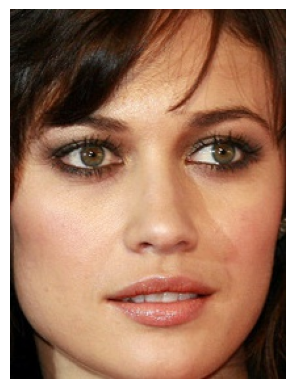

In [ ]:
sample = rnd.choice(train_images)
image = load_img(os.path.join(train_dir, sample))
print(type(image))
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path(r"/content/extracted_images/train")
new_base_dir = pathlib.Path(r"/content/my_images")

def make_subset(subset_name, start_ratio, end_ratio):
    for category in ("0", "1"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        files = [f for f in os.listdir(original_dir) if f.startswith(category + "_") and f.endswith(".jpg")]
        num_files = len(files)

        start_index = int(start_ratio * num_files)
        end_index = int(end_ratio * num_files)

        fnames = files[start_index:end_index]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", 0, 0.7)
make_subset("validation", 0.7, 0.9)
make_subset("test", 0.9, 1)

In [ ]:
files_list = os.listdir("/content/my_images/test/0")

# Count the number of files
num_files = len(files_list)
print(num_files)
# Print the names of the files
for file_name in files_list:
    print(file_name)

118
0_453.jpg
0_315.jpg
0_780.jpg
0_419.jpg
0_1036.jpg
0_263.jpg
0_22.jpg
0_327.jpg
0_789.jpg
0_555.jpg
0_758.jpg
0_396.jpg
0_656.jpg
0_68.jpg
0_1065.jpg
0_936.jpg
0_373.jpg
0_571.jpg
0_524.jpg
0_962.jpg
0_297.jpg
0_107.jpg
0_397.jpg
0_523.jpg
0_96.jpg
0_569.jpg
0_732.jpg
0_889.jpg
0_819.jpg
0_1013.jpg
0_833.jpg
0_249.jpg
0_911.jpg
0_240.jpg
0_234.jpg
0_676.jpg
0_1025.jpg
0_446.jpg
0_985.jpg
0_804.jpg
0_351.jpg
0_300.jpg
0_619.jpg
0_1165.jpg
0_332.jpg
0_982.jpg
0_83.jpg
0_1063.jpg
0_530.jpg
0_598.jpg
0_445.jpg
0_924.jpg
0_1131.jpg
0_174.jpg
0_580.jpg
0_767.jpg
0_1153.jpg
0_504.jpg
0_1109.jpg
0_330.jpg
0_110.jpg
0_858.jpg
0_38.jpg
0_253.jpg
0_166.jpg
0_17.jpg
0_450.jpg
0_470.jpg
0_133.jpg
0_220.jpg
0_1089.jpg
0_686.jpg
0_885.jpg
0_681.jpg
0_439.jpg
0_693.jpg
0_715.jpg
0_80.jpg
0_746.jpg
0_320.jpg
0_142.jpg
0_477.jpg
0_925.jpg
0_221.jpg
0_579.jpg
0_519.jpg
0_16.jpg
0_967.jpg
0_707.jpg
0_1115.jpg
0_90.jpg
0_1038.jpg
0_998.jpg
0_548.jpg
0_878.jpg
0_845.jpg
0_73.jpg
0_595.jpg
0_886.jpg
0_21

In [ ]:
train_path="/content/my_images/train"
test_path="/content/my_images/test"
val_path="/content/my_images/validation"

In [ ]:
df["CATEGORIES"] = df["CATEGORIES"].replace({0: 'man', 1: 'woman'})

In [ ]:

files_list = os.listdir(train_path)

# Count the number of files
num_files = len(files_list)
print(num_files)
# Print the names of the files
for file_name in files_list:
    print(file_name)

2
0
1


# 4. Image Augmentation: Enhance model generalization

In [ ]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

data_generator_2 = ImageDataGenerator (rescale=1./255)
data_generator_3 = ImageDataGenerator (rescale=1./255)

In [ ]:
train_generator = data_generator_1.flow_from_directory(
    directory = train_path, # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

val_generator=data_generator_2.flow_from_directory(
    directory = val_path, # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42
)
test_generator = data_generator_3.flow_from_directory(
    directory = test_path, # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)


Found 1614 images belonging to 2 classes.
Found 461 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


# 5. EDA

## 5.1 Distribution of Class Label

In [ ]:
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'0': 0, '1': 1}
Class labels: ['0', '1']


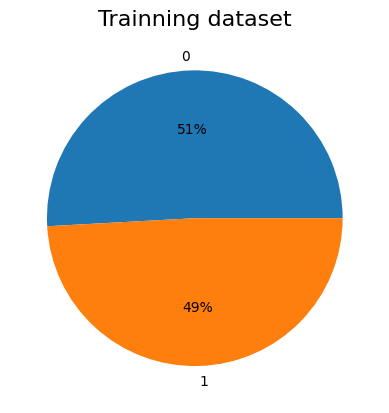

In [ ]:

frequency = np.unique(train_generator.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [ ]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator.classes))
print("Number of man images:", len([label for label in train_generator.classes if label == 0]))
print("Number of female images:", len([label for label in train_generator.classes if label == 1]))
print()
print("Dataset Characteristics of Validation Data Set:")
print("Number of images:", len(val_generator.classes))
print("Number of man images:", len([label for label in val_generator.classes if label == 0]))
print("Number of female images:", len([label for label in val_generator.classes if label == 1]))
print()
print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of man images:", len([label for label in test_generator.classes if label == 0]))
print("Number of female images:", len([label for label in test_generator.classes if label == 1]))
print()


Dataset Characteristics of Train Data Set:
Number of images: 1614
Number of man images: 821
Number of female images: 793

Dataset Characteristics of Validation Data Set:
Number of images: 461
Number of man images: 234
Number of female images: 227

Dataset Characteristics of Test Data Set:
Number of images: 232
Number of man images: 118
Number of female images: 114



## 5.2 Class Weights

In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 0.9829476248477467, 1: 1.0176544766708702}

## 5.3 Image Samples

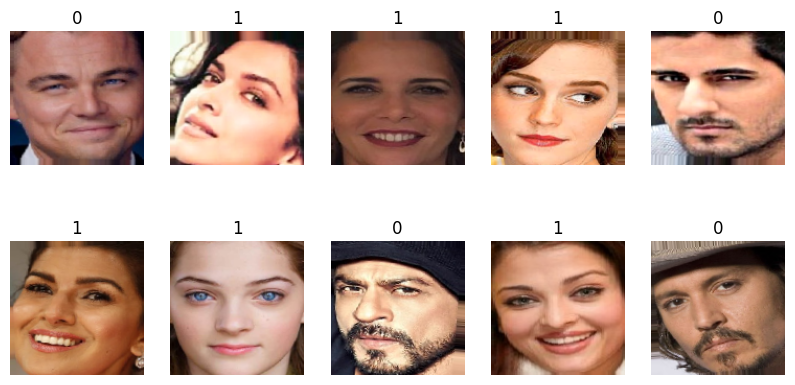

In [ ]:
img, label = next(train_generator)


plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()


# 6. Convolutional neural networks (CNNs)

In [ ]:
# Define the epochs for training
EPOCHS = 10

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', #Monitor validation accuracy
                               patience=2, #wait 2 epochs before stopping
                               verbose=1,
                               restore_best_weights=True #Revert to the best parameters after stopping
                              )
#The ReduceLROnPlateau callback reduces the learning rate when the validation accuracy stops improving.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',# Monitor validation accuracy
                              factor=0.001,# Multiply the learning rate by 0.001
                              patience=10,# Wait 10 epochs without improvement
                              verbose=1)


train_data = train_generator

## 6.1. InceptionV3

In [ ]:

# Load the pre-trained InceptionV3 model without the top classification layer
base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_Inception.layers:
    layer.trainable = False

# Create a new model and add the InceptionV3 base model
model_Inception = Sequential()
model_Inception.add(base_model_Inception)

# Add a global average pooling layer and output layer for classification
model_Inception.add(GlobalAveragePooling2D())
model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.4))
model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.2))

model_Inception.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (InceptionV3):")
model_Inception.summary()
print()

# Compile the model
model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)
# Validate the model
val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (InceptionV3):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,073,442 (84.20 MB)

 Trainable params: 270,658 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 103s 854ms/step - accuracy: 0.7276 - loss: 0.9733 - val_accuracy: 0.8836 - val_loss: 0.5103
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 73s 726ms/step - accuracy: 0.8523 - loss: 0.6150 - val_accuracy: 0.9009 - val_loss: 0.4560
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 73s 728ms/step - accuracy: 0.8811 - loss: 0.5309 - val_accuracy: 0.9095 - val_loss: 0.3799
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 71s 708ms/step - accuracy: 0.9003 - loss: 0.4382 - val_accuracy: 0.9224 - val_loss: 0.3472
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 712ms/step - accuracy: 0.8999 - loss: 0.4150 - val_accuracy: 0.8922 - val_loss: 0.3899
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 73s 721ms/step - accuracy: 0.8911 - loss: 0.4304 - val_accuracy: 0.9009 - val_loss: 0.3684
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - accuracy: 0.9239 - loss: 0.3535
Validation Loss: 0.3472
Validation Accuracy: 0.9224


## 6.2 VGG16

In [ ]:
# Load the pre-trained VGG16 model without the top classification layer
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_VGG16.layers:
    layer.trainable = False

# Create a new model and add the VGG16 base model
model_VGG16 = Sequential()
model_VGG16.add(base_model_VGG16)

# Add a fully connected layer and output layer for classification
model_VGG16.add(GlobalAveragePooling2D())
model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.4))
model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.2))
model_VGG16.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (VGG16):")
model_VGG16.summary()
print()

# Compile the model
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)
# Validate the model
val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_VGG16:.4f}')
print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (VGG16):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,788,738 (56.41 MB)

 Trainable params: 74,050 (289.26 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.6327 - loss: 0.8475 - val_accuracy: 0.7328 - val_loss: 0.6379
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.8267 - loss: 0.5154 - val_accuracy: 0.8578 - val_loss: 0.4244
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.8670 - loss: 0.4230 - val_accuracy: 0.9052 - val_loss: 0.3457
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.8881 - loss: 0.3625 - val_accuracy: 0.8966 - val_loss: 0.3371
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.8913 - loss: 0.3430 - val_accuracy: 0.9009 - val_loss: 0.3283
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9117 - loss: 0.3582
Validation Loss: 0.3457
Validation Accuracy: 0.9052


## 6.3 MobileNetV2

In [ ]:

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_MobileNet.layers:
    layer.trainable = False

# Create a new model and add the MobileNetV2 base model
model_MobileNet = Sequential()
model_MobileNet.add(base_model_MobileNet)

# Add a global average pooling layer and output layer for classification
model_MobileNet.add(GlobalAveragePooling2D())
model_MobileNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.4))
model_MobileNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.2))
model_MobileNet.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (MobileNetV2):")
model_MobileNet.summary()
print()

# Compile the model
model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_MobileNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (MobileNetV2):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 172,354 (673.26 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 313ms/step - accuracy: 0.6914 - loss: 0.8914 - val_accuracy: 0.8491 - val_loss: 0.6501
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 294ms/step - accuracy: 0.8782 - loss: 0.5135 - val_accuracy: 0.9009 - val_loss: 0.4519
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - accuracy: 0.9106 - loss: 0.4406 - val_accuracy: 0.8578 - val_loss: 0.5251
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.9222 - loss: 0.4012 - val_accuracy: 0.8966 - val_loss: 0.3966
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.9225 - loss: 0.4269
Validation Loss: 0.4519
Validation Accuracy: 0.9009


## 6.4 DenseNet

In [ ]:

# Load the pre-trained DenseNet121 model without the top classification layer
base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_DenseNet.layers:
    layer.trainable = False

# Create a new model and add the DenseNet121 base model
model_DenseNet = Sequential()
model_DenseNet.add(base_model_DenseNet)

# Add a global average pooling layer and output layer for classification
model_DenseNet.add(GlobalAveragePooling2D())
model_DenseNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_DenseNet.add(Dropout(0.4))
model_DenseNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_DenseNet.add(Dropout(0.2))
model_DenseNet.add(Dense(2, activation='softmax'))

# Model summary
print("Model Summary (DenseNet121):")
model_DenseNet.summary()
print()

# Compile the model
model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_DenseNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (DenseNet121):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,090 (27.38 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 7,037,504 (26.85 MB)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7777 - loss: 0.7633 - val_accuracy: 0.9483 - val_loss: 0.3495
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9035 - loss: 0.4093 - val_accuracy: 0.9483 - val_loss: 0.3232
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9187 - loss: 0.3661 - val_accuracy: 0.9397 - val_loss: 0.2891
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 818ms/step - accuracy: 0.9294 - loss: 0.3842
Validation Loss: 0.3495
Validation Accuracy: 0.9483


## 6.5 Comparing model performance

In [ ]:
data = {
    'InceptionV3': val_accuracy_Inception,
    'VGG16': val_accuracy_VGG16,
    'MobileNet': val_accuracy_MobileNet,
    'DenseNet': val_accuracy_DenseNet,
}


In [ ]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

In [ ]:
df

model  accuracy
0  InceptionV3  0.922414
1        VGG16  0.905172
2    MobileNet  0.900862
3     DenseNet  0.948276

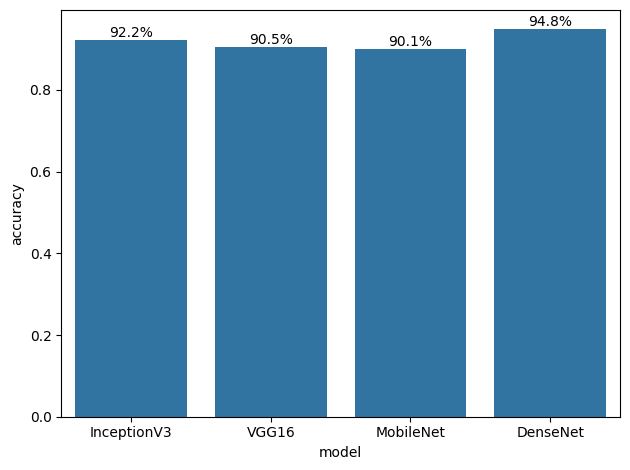

In [ ]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

## 7.Fine-tune Modelling

In [ ]:
# Unfreeze the base_model
no_base_layers = len(model_Inception.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


In [ ]:
# Fine-tune the model
model_Inception.trainable = True
for layer in model_Inception.layers[: -no_finetune_layers]:
    layer.trainable = False

# small learning rate for fine tuning
model_Inception.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 85s 745ms/step - accuracy: 0.8986 - loss: 0.3018 - val_accuracy: 0.9181 - val_loss: 0.2122
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 70s 691ms/step - accuracy: 0.8899 - loss: 0.3132 - val_accuracy: 0.9138 - val_loss: 0.2119
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 69s 686ms/step - accuracy: 0.8703 - loss: 0.3603 - val_accuracy: 0.9138 - val_loss: 0.2116
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Validate the model
print('====== Model Validation ======')
val_loss_finetune_Inception, val_accuracy_finetune_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_finetune_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_finetune_Inception:.4f}')

====== Model Validation ======
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - accuracy: 0.9348 - loss: 0.1975
Validation Loss: 0.2122
Validation Accuracy: 0.9181


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
# val_generator.reset()
Inception_test_preds = model_Inception.predict(test_generator)
Inception_test_pred_classes = np.argmax(Inception_test_preds, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 757ms/step


## 8. Prediction Result Samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


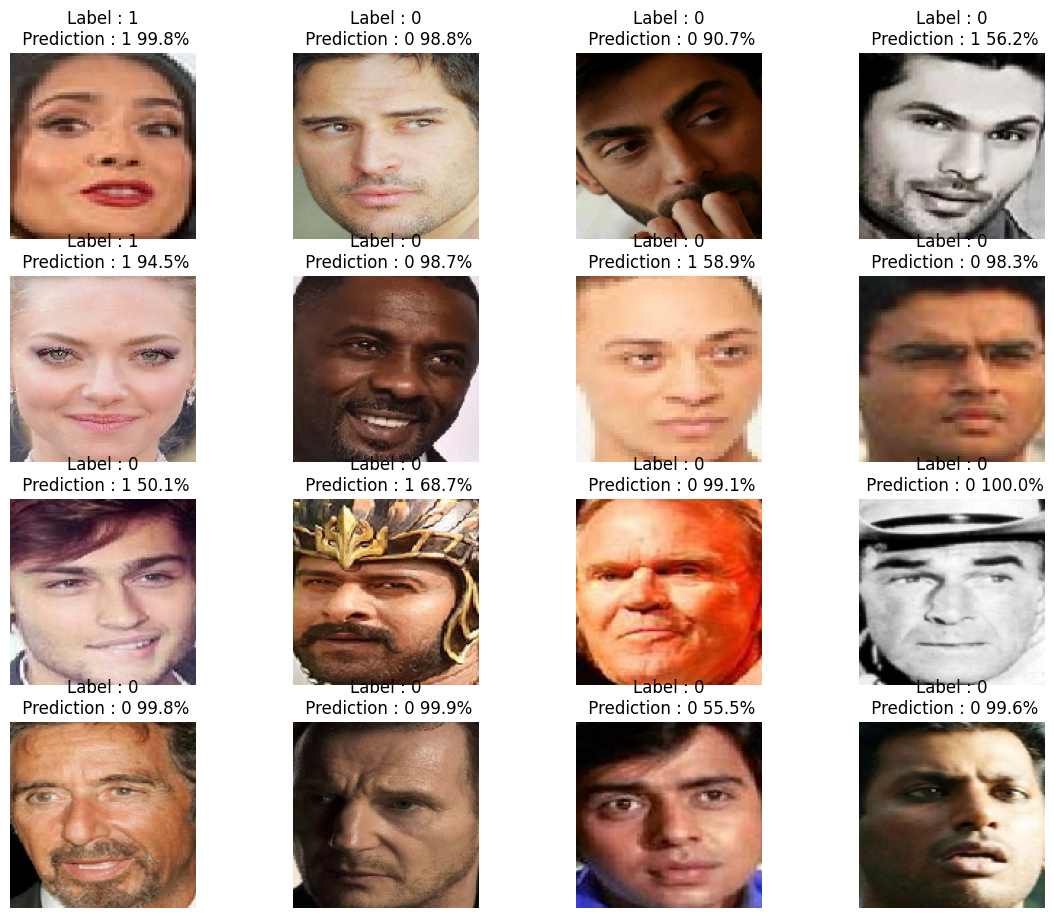

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


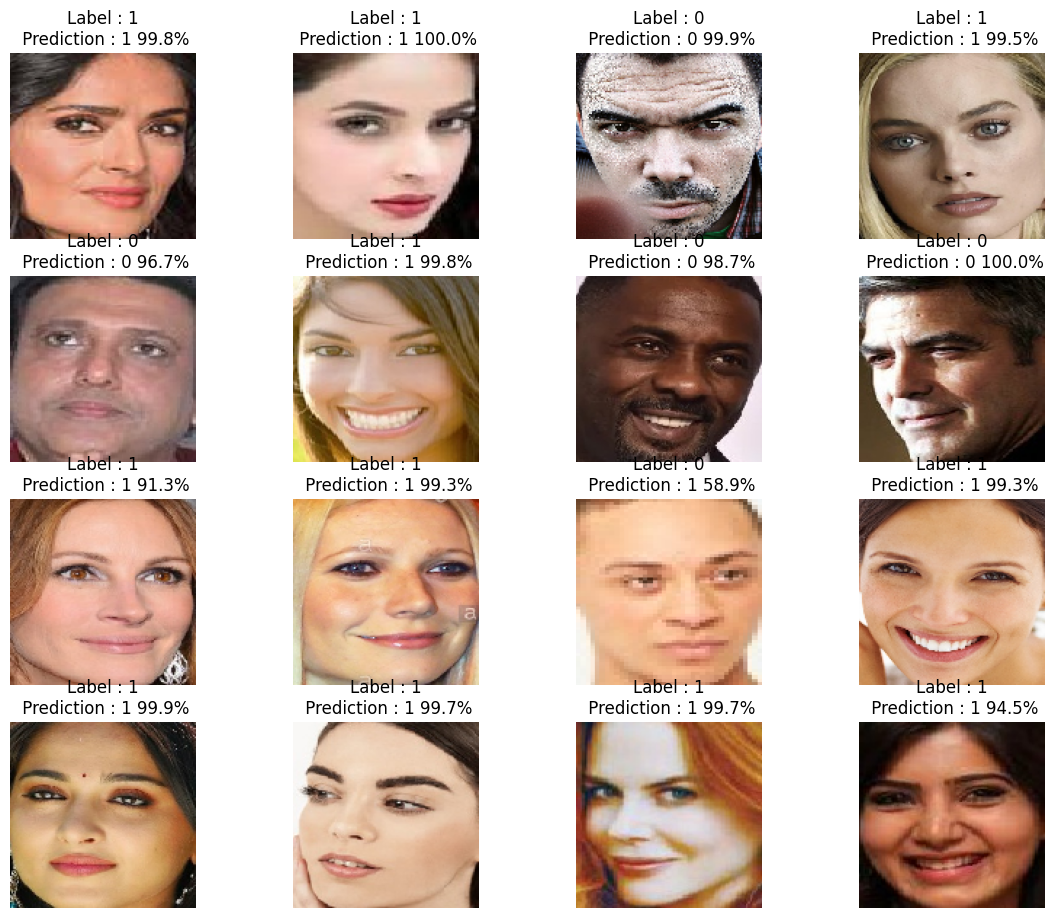

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


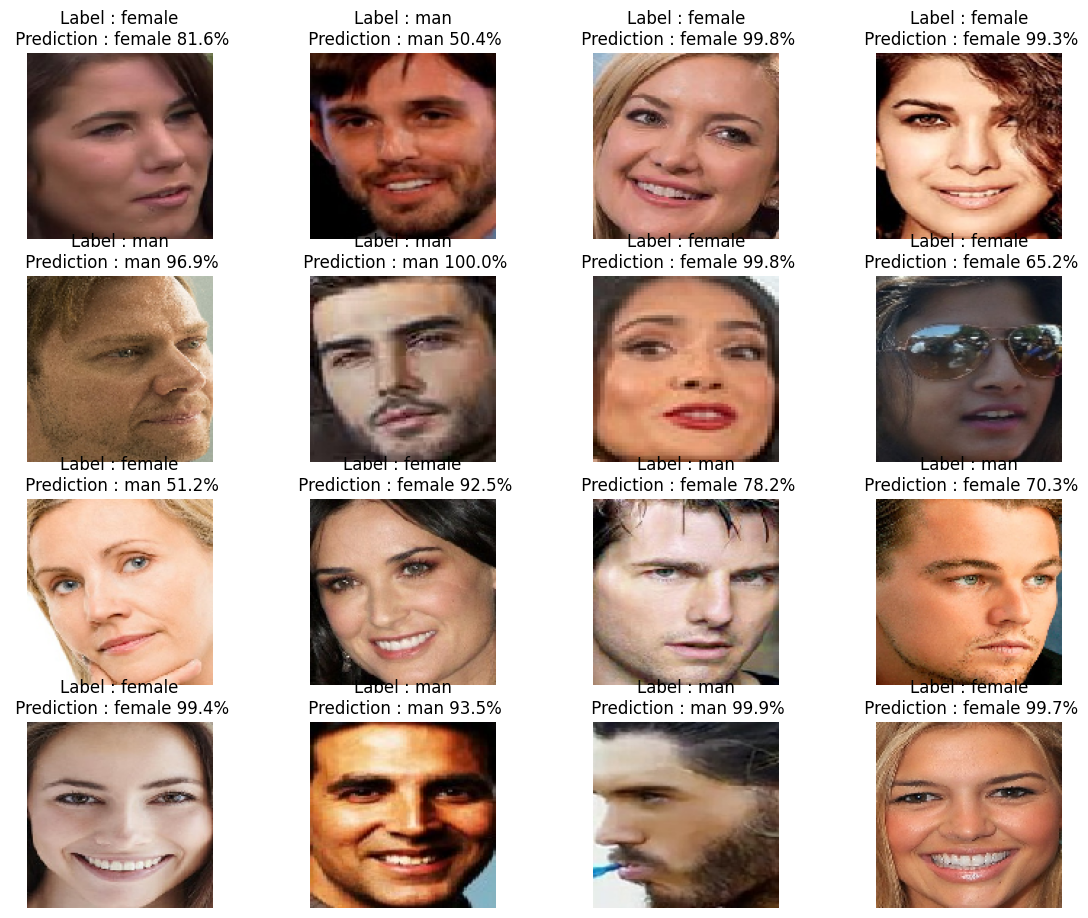

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

label_mapping = {
    0: 'man',
    1: 'female'
}

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(
        label_mapping[np.argmax(label[i])],
        label_mapping[test_pred_classes[i]],
        100 * np.max(prediction[i])
    ))
plt.show()

# Conclusion:

This project develops a CNN-based model to predict gender from images. Four architectures—InceptionV3, VGG16, MobileNet, and DenseNet—were evaluated, with InceptionV3 achieving the highest accuracy through fine-tuned modeling. Future improvements include optimizing hyperparameters and integrating preprocessing techniques for better performance and real-time deployment.